In [ ]:
from

In [2]:
from src.data_loading import load_data
import numpy as np
for data_name in ["journal_jcr_cls", "movies", "michelin", "spotify", "employee_salary", "drug_directory", "museums", "fifa_footballplayers_22", "jp_anime"]:
    X, y = load_data(data_name, max_rows=None)
    print(np.unique(y, return_counts=True))


Task: classification for journal_jcr_cls
(array([0., 1.]), array([3133, 2577]))
Task: regression for movies
(array([False,  True]), array([3104, 3103]))
Task: classification for michelin
(array([0, 1]), array([3387, 3445]))
Task: classification for spotify
(array([0, 1]), array([20551, 20548]))
Task: regression for employee_salary
(array([False,  True]), array([4615, 4613]))
Task: classification for drug_directory
(array(['CELLULAR THERAPY', 'HUMAN OTC DRUG', 'HUMAN PRESCRIPTION DRUG',
       'NON-STANDARDIZED ALLERGENIC', 'PLASMA DERIVATIVE',
       'STANDARDIZED ALLERGENIC', 'VACCINE'], dtype=object), array([    7, 69001, 47735,  2927,   290,   142,   113]))
Task: regression for museums
(array([False,  True]), array([5735, 5732]))
Task: regression for fifa_footballplayers_22
(array([False,  True]), array([9650, 9515]))
Task: regression for jp_anime
(array([False,  True]), array([7643, 7636]))


In [18]:
import pandas as pd

pd.read_parquet("../data/videogame_sales.parquet")

,name,platform,year,genre,publisher,target
0,Wii Sports,Wii,2006,Sports,Nintendo,1.0
1,Super Mario Bros.,NES,1985,Platform,Nintendo,1.0
2,Mario Kart Wii,Wii,2008,Racing,Nintendo,1.0
3,Wii Sports Resort,Wii,2009,Sports,Nintendo,1.0
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,1.0
...,...,...,...,...,...,...
1842,Need for Speed: ProStreet,Wii,2007,Racing,Electronic Arts,0.0
1843,Pikmin 3,WiiU,2013,Strategy,Nintendo,0.0
1844,Legend of Mana,PS,1999,Role-Playing,SquareSoft,0.0
1845,Lumines: Puzzle Fusion,PSP,2004,Puzzle,Ubisoft,0.0


In [1]:
from dirty_cat.datasets import fetch_employee_salaries, fetch_drug_directory
from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm
import numpy as np
ds = fetch_employee_salaries()
#ds = fetch_drug_directory()

In [2]:
X_original, y_original = ds.X, ds.y
# limit to 10K samples
X_original = X_original[:10000]
y_original = y_original[:10000]
column_to_consider = "employee_position_title"
# Dropping NA rows in X_original based on specified columns
#X_original = X_original.dropna(subset=["gender", column_to_consider, "year_first_hired"])
X_original, y_original = X_original.reset_index(drop=True), y_original.reset_index(drop=True)
X_original = X_original.dropna(subset=[column_to_consider])

# Keeping only the rows in y_original that correspond to the remaining rows in X_original
y_original = y_original.loc[X_original.index]

# label encoding
##y_original = y_original.astype('category')
#y_original = y_original.cat.codes
y_original = y_original > np.median(y_original)

In [3]:
from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm
import numpy as np

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Move the model to GPU
model.to('cuda')

# Sample data: list of column_to_consider
employee_position_titles = X_original[column_to_consider].tolist()

# Function to get BERT embeddings
def get_bert_embedding(sentences):
    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt", max_length=128)
    
    # Move the inputs to GPU
    inputs = {name: tensor.to('cuda') for name, tensor in inputs.items()}
    
    with torch.no_grad():  # Deactivates autograd, reducing memory usage and speeding up computations
        outputs = model(**inputs)
        
    # Using the [CLS] token embedding as sentence embedding
    sentence_embeddings = outputs.last_hidden_state[:, 0, :].cpu().detach().numpy()
    return sentence_embeddings

# Batch the titles (you can adjust the batch size based on your GPU's capabilities)
batch_size = 32  # Batch size of 2 as an example
batches = [employee_position_titles[i:i + batch_size] for i in range(0, len(employee_position_titles), batch_size)]

# Process the batches
all_embeddings = []
for batch in tqdm(batches):
    batch_embeddings = get_bert_embedding(batch)
    all_embeddings.append(batch_embeddings)

# Combine the batches back into a single array
final_embeddings = np.vstack(all_embeddings)


100%|██████████| 289/289 [00:03<00:00, 76.83it/s]


ic| 3312114651.py:25 in train_regression() at 16:38:29.949
/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
ic| 3312114651.py:25 in train_regression() at 16:38:31.084
ic| 3312114651.py:25 in train_regression() at 16:38:31.133
ic| 3312114651.py:32 in train_hist_gradient_boosting() at 16:38:31.175
ic| 3312114651.py:32 in train_hist_gradient_boosting() at 16:38:38.127
ic| 3312114651.py:38 in train_tabpfn() at 16:38:43.526


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


ic| 3312114651.py:38 in train_tabpfn() at 16:38:49.054


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Full Embedding with Linear Regression
Accuracy: 0.8238940204180846
PCA with Linear Regression
Accuracy: 0.8153864851725814
Subset with Linear Regression
Accuracy: 0.797277588721439
PCA with HistGradientBoostingRegressor
Accuracy: 0.8112542537676227
Subset with HistGradientBoostingRegressor
Accuracy: 0.8141711229946524
PCA with TabPFNClassifier
Accuracy: 0.8251093825960136
Subset with TabPFNClassifier
Accuracy: 0.8248663101604278
Skrub
Accuracy: 0.8215848322800194
Random
Accuracy: 0.5058337384540593


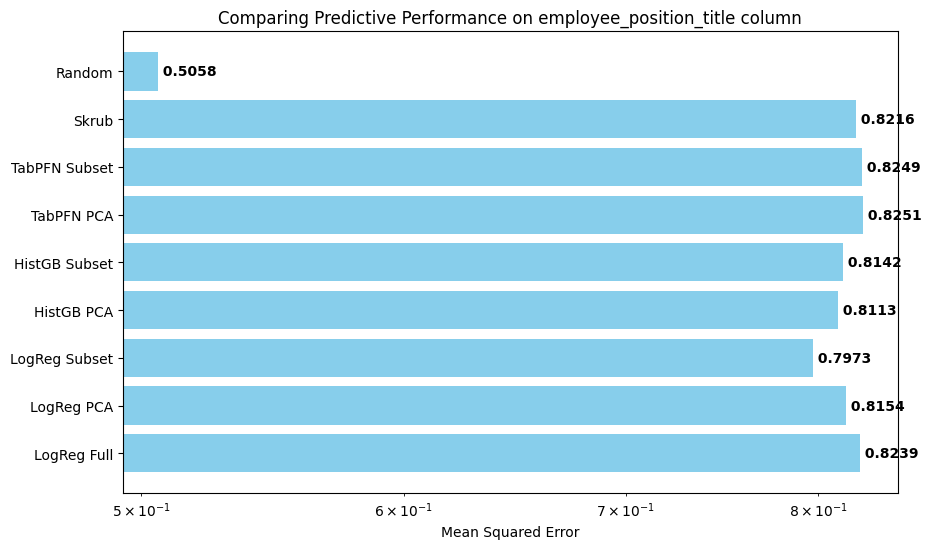

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from tabpfn import TabPFNClassifier
import numpy as np
from icecream import ic

# Function to get embeddings (replace with your BERT embeddings)
def get_fake_embeddings(n, dim):
    return np.random.randn(n, dim)

# Apply PCA
def apply_pca(embeddings, n_components):
    # normalize embeddings
    #embeddings = PowerTransformer().fit_transform(embeddings)
    #embeddings = StandardScaler().fit_transform(embeddings)
    pca = PCA(n_components=n_components)
    return pca.fit_transform(embeddings)

# Linear Regression Model
def train_regression(X_train, y_train, X_test):
    ic()
    model = LogisticRegression()
    model.fit(X_train, y_train)
    return model.predict(X_test)

# HistGradientBoostingRegressor Model
def train_hist_gradient_boosting(X_train, y_train, X_test):
    ic()
    model = HistGradientBoostingClassifier()
    model.fit(X_train, y_train)
    return model.predict(X_test)

def train_tabpfn(X_train, y_train, X_test):
    ic()
    model = TabPFNClassifier()
    model.fit(X_train, y_train)
    return model.predict(X_test)

# Generate fake data and embeddings (replace with your actual data and embeddings)
n_samples = 1000
n_features = 768  # BERT base has 768 dimensions
#X = get_fake_embeddings(n_samples, n_features)
# X is final_embeddings, year_first_hired and gender (ordinal encoded)
#X = np.concatenate((final_embeddings, 
                    #X_original['year_first_hired'].values.reshape(-1, 1), 
                    #OrdinalEncoder().fit_transform(np.array(X_original['gender']).reshape(-1, 1)).reshape(-1, 1)), axis=1)
X = final_embeddings
#y = y_original > np.median(y_original)
y = y_original
# restict to 1000 samples
X_train = X[:1000]
y_train = y[:1000]
X_test = X[1000:]
y_test = y[1000:]

# Train-test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Full Embedding with Linear Regression
y_pred_full = train_regression(X_train, y_train, X_test)

# PCA with Linear Regression
#X_train_pca = apply_pca(X_train, 50)
#X_test_pca = apply_pca(X_test, 50)
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
y_pred_pca = train_regression(X_train_pca, y_train, X_test_pca)

# Subset with Linear Regression
X_train_subset = X_train[:, :50]
X_test_subset = X_test[:, :50]
# take 50 evenly spaced columns
#X_train_subset = X_train[:, ::(n_features//50)]
#X_test_subset = X_test[:, ::(n_features//50)]
y_pred_subset = train_regression(X_train_subset, y_train, X_test_subset)

# PCA with HistGradientBoostingRegressor
y_pred_hist_pca = train_hist_gradient_boosting(X_train_pca, y_train, X_test_pca)

# Subset with HistGradientBoostingRegressor
y_pred_hist_subset = train_hist_gradient_boosting(X_train_subset, y_train, X_test_subset)

#PCA with TabPFNClassifier
y_pred_tabpfn_pca = train_tabpfn(X_train_pca, y_train, X_test_pca)

#Subset with TabPFNClassifier
y_pred_tabpfn_subset = train_tabpfn(X_train_subset, y_train, X_test_subset)


# Skrub
###########
from dirty_cat import MinHashEncoder
from sklearn.ensemble import HistGradientBoostingClassifier

# Initialize MinHashEncoder
encoder = MinHashEncoder()

X_train_enc = encoder.fit_transform(np.array(X_original[column_to_consider][:1000]).reshape(-1, 1))
X_test_enc = encoder.transform(np.array(X_original[column_to_consider][1000:]).reshape(-1, 1))

# Initialize HistGradientBoostingClassifier
model = HistGradientBoostingClassifier()

# Train the model
model.fit(X_train_enc, y_train)

# predict
y_pred_skrub = model.predict(X_test_enc)

# random prediction, weighted by class distribution
classes, counts = np.unique(y_train, return_counts=True)
y_pred_random = np.random.choice(classes, size=len(y_test), p=counts/len(y_train))
################

# Evaluate models
print("Full Embedding with Linear Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_full))
print("PCA with Linear Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_pca))
print("Subset with Linear Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_subset))
print("PCA with HistGradientBoostingRegressor")
print("Accuracy:", accuracy_score(y_test, y_pred_hist_pca))
print("Subset with HistGradientBoostingRegressor")
print("Accuracy:", accuracy_score(y_test, y_pred_hist_subset))
print("PCA with TabPFNClassifier")
print("Accuracy:", accuracy_score(y_test, y_pred_tabpfn_pca))
print("Subset with TabPFNClassifier")
print("Accuracy:", accuracy_score(y_test, y_pred_tabpfn_subset))
print("Skrub")
print("Accuracy:", accuracy_score(y_test, y_pred_skrub))
print("Random")
print("Accuracy:", accuracy_score(y_test, y_pred_random))



import matplotlib.pyplot as plt

# Calculate accuracy
acc_full = accuracy_score(y_test, y_pred_full)
acc_pca = accuracy_score(y_test, y_pred_pca)
acc_subset = accuracy_score(y_test, y_pred_subset)
acc_hist_pca = accuracy_score(y_test, y_pred_hist_pca)
acc_hist_subset = accuracy_score(y_test, y_pred_hist_subset)
acc_tabpfn_pca = accuracy_score(y_test, y_pred_tabpfn_pca)
acc_tabpfn_subset = accuracy_score(y_test, y_pred_tabpfn_subset)
acc_skrub = accuracy_score(y_test, y_pred_skrub)
acc_random = accuracy_score(y_test, y_pred_random)

# Prepare data for plotting
labels = ['LogReg Full', 'LogReg PCA', 'LogReg Subset', 'HistGB PCA', 'HistGB Subset', 'TabPFN PCA', 'TabPFN Subset', 'Skrub', 'Random']
acc_values = [acc_full, acc_pca, acc_subset, acc_hist_pca, acc_hist_subset, acc_tabpfn_pca, acc_tabpfn_subset, acc_skrub, acc_random]
# Create the plot
plt.figure(figsize=(10, 6))
plt.barh(labels, acc_values, color='skyblue')
plt.xlabel('Mean Squared Error')
plt.title(f'Comparing Predictive Performance on {column_to_consider} column')
for i, v in enumerate(acc_values):
    plt.text(v, i, f" {v:.4f}", color='black', va='center', fontweight='bold')
plt.xscale('log')
plt.show()
